### Written by Federica B. Bianco @fedhere
### for NYU CUSP PUI

For Assignment 2 you should design your own investigation into the citibike data.
Come up with a question about the Citibike data usage. It can be anything that involves Categorical data. 
At this point of the class it is easier to run tests of proportions or similar, and work with categorical data. Categorical cn be anhything that can be punt into classes (e.g. day/night, male/female, 2014/2015/2016.... as long as you set up your experiment the proper way!)
- Choose the significance threshold
- Clearly state they Null and Alternate hypothesis
- Wrangle the data so that it is ready for your analysis.

In [1]:
from __future__  import print_function, division
__author__ = 'uak211'
import pandas as pd
import numpy as np
import os
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import seaborn as sn

plt.rcParams.update({'font.size': 14})
%matplotlib inline
print('puidata:', os.getenv('PUIDATA'))

puidata: /nfshome/uak211/PUIdata


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#### download data, move data to puidata directory, read as csvs, concatenate dfs, select columns of interest

In [2]:
# start here if downloading 
def get_citibike_data(datestring):
    '''
    Downloads and unzips citibike csv data into the $PUIDATA directory.
    Arguments:
        date string in format yyyymm
    ''' 
    file_root = '{}-citibike-tripdata'.format(datestring)
    if not ('2018' or '2017') in datestring:
        url = 'https://s3.amazonaws.com/tripdata/{}.zip'.format(file_root)
    else:
        url = 'https://s3.amazonaws.com/tripdata/{}.csv.zip'.format(file_root)

    r = requests.get(url)
    zip_ref = zipfile.ZipFile(io.BytesIO(r.content), 'r')
    zip_ref.extractall(os.getenv('PUIDATA'))
    zip_ref.close()

In [3]:
winter_date = '201801'
summer_date = '201807'
get_citibike_data(winter_date)
get_citibike_data(summer_date)

In [4]:
# start here if the data already exists locally
winter_date = '201801'
summer_date = '201807'
summer_file = '{}-citibike-tripdata'.format(summer_date)
winter_file = '{}-citibike-tripdata'.format(winter_date)
summer_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), summer_file))
winter_bikes = pd.read_csv('{}/{}.csv'.format(os.getenv('PUIDATA'), winter_file))

In [5]:
dfs = [winter_bikes, summer_bikes]
bikes = pd.concat(dfs)
bikes.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1


In [6]:
drop_cols = ['start station id', 'stoptime','start station name',
             'start station latitude', 'start station longitude', 
            'end station id', 'end station name', 'end station latitude', 
             'end station longitude', 'bikeid', 'birth year', 'gender']
bikes.drop(drop_cols, axis = 1, inplace = True)
list(bikes)

['tripduration', 'starttime', 'usertype']

#### IDEA:
regular citibike users take shorter trips during winter months than summer months because it's cold

#### NULL HYPOTHESIS:
the average length of a citibike subscriber's trip is the same or longer during a winter month than a summer month

#### _$H_0$_ : $\overline{L}_{\mathrm{summer}} <= \overline{L}_{\mathrm{winter}}$
#### _$H_1$_ : $\overline{L}_{\mathrm{summer}} > \overline{L}_{\mathrm{winter}}$
statistical significance level: $\alpha=0.05$

#### further data prep
* dummy code winter/summer variable
* limit dataset to subscribers

In [7]:
bikes['summer_month'] = bikes.starttime.str.contains('2018-07')*1
bikes = bikes[bikes.usertype.str.contains('Customer') == False]
bikes.head()

,tripduration,starttime,usertype,summer_month
0,970,2018-01-01 13:50:57.4340,Subscriber,0
1,723,2018-01-01 15:33:30.1820,Subscriber,0
2,496,2018-01-01 15:39:18.3370,Subscriber,0
3,306,2018-01-01 15:40:13.3720,Subscriber,0
4,306,2018-01-01 18:14:51.5680,Subscriber,0


#### initial plotting

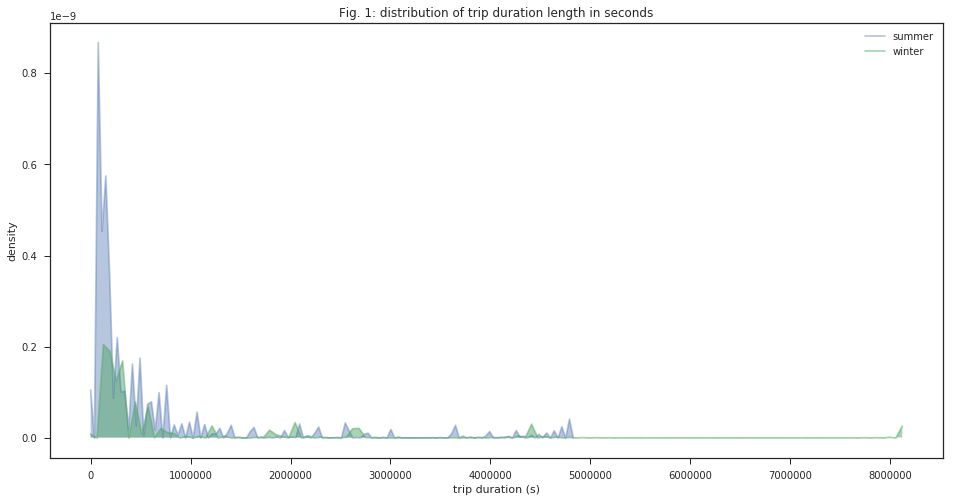

In [8]:
summer = bikes.loc[bikes['summer_month'] == 1]
winter = bikes.loc[bikes['summer_month'] == 0]

plt.style.use('seaborn-ticks')
fig, ax = plt.subplots(figsize = (16, 8))
ax.set(xlabel = 'trip duration (s)', ylabel = 'density', 
       title = 'Fig. 1: distribution of trip duration length in seconds')
sn.kdeplot(summer['tripduration'], bw = 12, shade = True, label = 'summer', alpha = 0.4)
sn.kdeplot(winter['tripduration'], bw = 12, shade = True, label = 'winter', alpha = 0.5)
plt.legend()

Fig. 1: Kernel Density Estimate plots of citibike trip duration distributions for one summer month and one winter month. Both distributions have highly positive skews like the lognormal distribution. 